In [1]:
# Importing libraries
import pandas as pd # data science essentials
import matplotlib.pyplot as plt # essential graphical output
import seaborn as sns # enhanced graphical output
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

## importing data ##

# reading modeling data into Python
modeling_data = './datasets/train.csv'

# calling this df_train
df_train = pd.read_csv(modeling_data,
                      index_col  = 'entry_id')

# reading testing data into Python
testing_data = './datasets/test.csv'

# calling this df_test
df_test = pd.read_csv(testing_data,
                      index_col  = 'entry_id'
                     )

In [2]:
# concatenating datasets together for mv analysis and feature engineering
df_train['set'] = 'Not Kaggle'
df_test ['set'] = 'Kaggle'

# concatenating both datasets together for mv and feature engineering
df = pd.concat(objs = [df_train, df_test],
                    axis = 0,
                    ignore_index = False)

# checking data
df.head(n = 5)

,Publisher Name,Keyword,Match Type,Campaign,Keyword Group,Category,Bid Strategy,Status,Search Engine Bid,Clicks,...,Avg. Cost per Click,Impressions,Engine Click Thru %,Avg. Pos.,Trans. Conv. %,Total Cost/ Trans.,Amount,Total Cost,Total Volume of Bookings,set
entry_id,,,,,,,,,,,,,,,,,,,,,
mkt_814,Google - US,[air france],Exact,Air France Branded,Air France Brand,uncategorized,NaN,Live,27.5,30418.0,...,0.44,188409.0,0.16,1.27,0.01,30.38,515791.90,13336.81,439.0,Not Kaggle
mkt_1536,Yahoo - US,airfrance,Advanced,Air France Branded,Air France Website,uncategorized,NaN,Live,7.5,23893.0,...,0.75,162070.0,0.15,1.60,0.02,42.61,567463.40,17939.35,421.0,Not Kaggle
mkt_1349,Google - Global,[air france],Exact,Air France Brand & French Destinations,Air France Brand,uncategorized,NaN,Unavailable,5.0,14713.0,...,1.04,44023.0,0.33,1.02,0.02,66.36,264650.90,15329.74,231.0,Not Kaggle
mkt_007,Google - US,air france,Broad,Air France Branded,Air France Brand,uncategorized,NaN,Live,27.5,29060.0,...,1.59,385476.0,0.08,1.44,0.01,206.20,290609.90,46188.44,224.0,Not Kaggle
mkt_2839,Google - US,airfrance,Broad,Air France Branded,Air France Brand,uncategorized,NaN,Live,27.5,11789.0,...,0.20,78814.0,0.15,1.13,0.02,11.07,216915.75,2412.51,218.0,Not Kaggle


In [3]:
# Renaming features
df = df.rename(columns={
    'Total Volume of Bookings' : 'Total_Volume_of_Bookings',
    'Publisher Name' : 'Publisher_Name',
    'Match Type': 'Match_Type',
    'Keyword Group': 'Keyword_Group',
    'Bid Strategy': 'Bid_Strategy',
    'Search Engine Bid': 'Search_Engine_Bid'
})

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Missing Values Analysis & Imputation</b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />


In [4]:
# Missing Values Imputation
# Find missing values in the dataset
missing_values = df.isnull().sum().sort_values(ascending = False)
missing_values

# 2 features in our df have missing values - Bid Strategy and Match Type.
# Separate strategies have been followed to impute missing values for each one of them. 

Bid_Strategy                1224
Total_Volume_of_Bookings     100
Match_Type                    48
Publisher_Name                 0
Impressions                    0
Total Cost                     0
Amount                         0
Total Cost/ Trans.             0
Trans. Conv. %                 0
Avg. Pos.                      0
Engine Click Thru %            0
Click Charges                  0
Avg. Cost per Click            0
Keyword                        0
Clicks                         0
Search_Engine_Bid              0
Status                         0
Category                       0
Keyword_Group                  0
Campaign                       0
set                            0
dtype: int64

In [5]:
# Checking the most common "Bid Strategy" for each "Campaign"
common_bid_strategy_per_campaign = df.groupby('Campaign')['Bid_Strategy'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else np.nan)
common_bid_strategy_per_campaign.head()

Campaign
Air France Brand & French Destinations    Position 2-5 Bid Strategy
Air France Branded                             Position 1 -2 Target
Air France Global Campaign                            Position 1- 3
Business Class                            Position 2-5 Bid Strategy
French Destinations                       Position 2-5 Bid Strategy
Name: Bid_Strategy, dtype: object

__Imputation Strategy__:

1. For Bid Strategy, the mode of Bid Strategy for each campaign has been taken and filled for the missing values in the Bid Strategy.
2. For Geo Targeted Atlanta, Geo Targeted Cincinnati - 'Position 5-10 Bid Strategy' has been imputed which is common across all Geo Targeted campaigns. 
3. For Match Type missing values - filling with 'Broad' as most of the missing values across Match Type were belonging to Google_Yearlong2006 and Air France Global Campaign which have 'Broad' as their Mode for Match Type

In [6]:
# Iterate over each campaign and its most common bid strategy
for campaign, strategy in common_bid_strategy_per_campaign.items():
    
    # Check if the strategy is not Na
    if pd.notna(strategy):
        # Select rows where Campaign matches and 'Bid Strategy' is missing
        mask = (df['Campaign'] == campaign) & (df['Bid_Strategy'].isnull())
        # Impute with the most common strategy for this campaign
        df.loc[mask, 'Bid_Strategy'] = strategy
        
# Specify the campaigns without any values
campaigns_without_mode = ["Geo Targeted Atlanta", "Geo Targeted Cincinnati"]
fill_strategy = "Position 5-10 Bid Strategy"

# Impute the specified fill strategy for these campaigns
for campaign in campaigns_without_mode:
    mask = (df['Campaign'] == campaign) & (df['Bid_Strategy'].isnull())
    df.loc[mask, 'Bid_Strategy'] = fill_strategy

In [7]:
# Fill missing 'Match Type' values with 'Broad'
df['Match_Type'].fillna('Broad', inplace=True)

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Exploratory Data Analysis </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

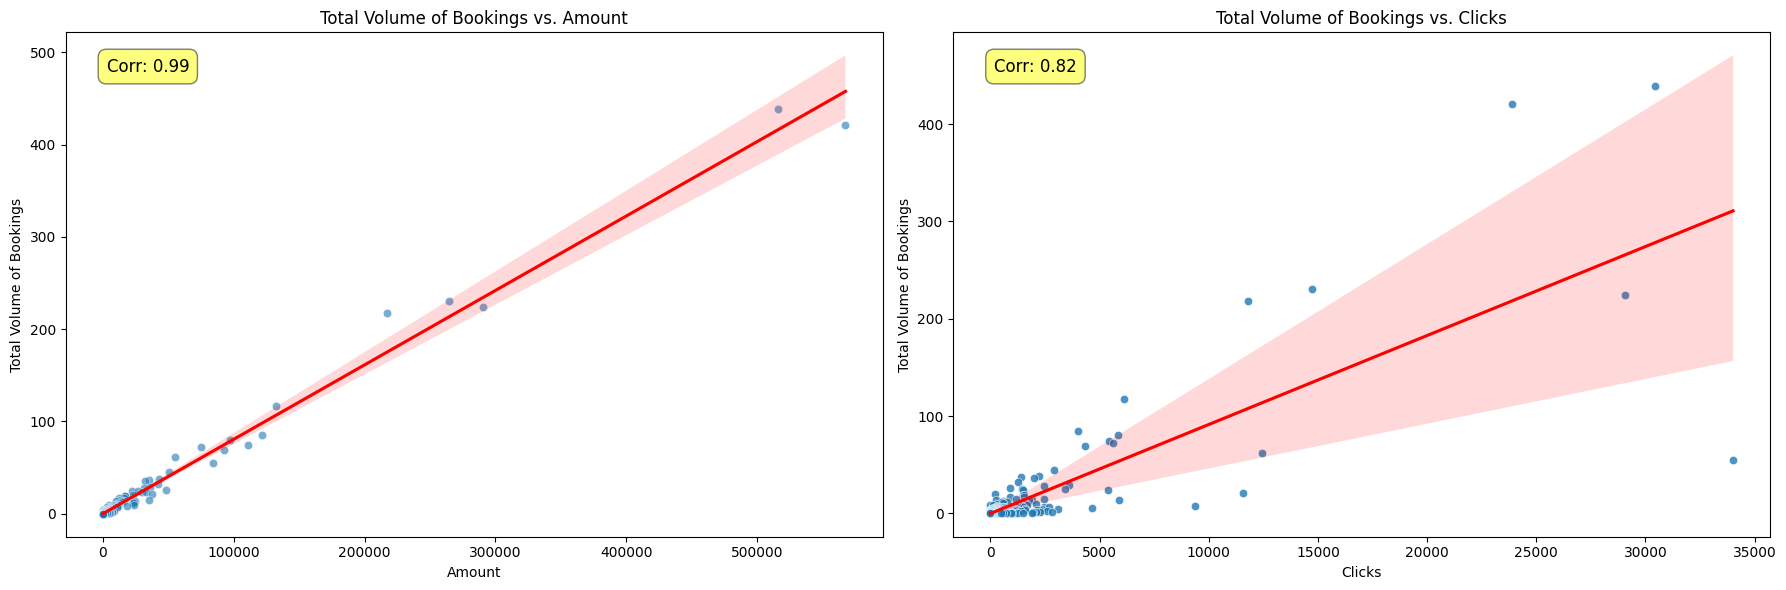

In [8]:
# Create subplots for the two scatter plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Total Volume of Bookings vs. Amount Scatter Plot
sns.scatterplot(ax=axes[0], data=df, x='Amount', y='Total_Volume_of_Bookings', alpha=0.6)
sns.regplot(ax=axes[0], data=df, x='Amount', y='Total_Volume_of_Bookings', scatter=False, color='red')
axes[0].set_title('Total Volume of Bookings vs. Amount')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Total Volume of Bookings')

# Total Volume of Bookings vs. Clicks Scatter Plot
sns.scatterplot(ax=axes[1], data=df, x='Clicks', y='Total_Volume_of_Bookings', alpha=0.8)
sns.regplot(ax=axes[1], data=df, x='Clicks', y='Total_Volume_of_Bookings', scatter=False, color='red')
axes[1].set_title('Total Volume of Bookings vs. Clicks')
axes[1].set_xlabel('Clicks')
axes[1].set_ylabel('Total Volume of Bookings')

# Calculate the correlation matrix
df_selected = df[['Total_Volume_of_Bookings', 'Amount', 'Clicks']]
correlation_selected = df_selected.corr()

# Extract the specific correlation coefficients
bookings_amount_corr = correlation_selected.loc['Total_Volume_of_Bookings', 'Amount']
bookings_clicks_corr = correlation_selected.loc['Total_Volume_of_Bookings', 'Clicks']

# Annotate the correlation coefficient on the plots
axes[0].text(0.05, 0.95, f'Corr: {bookings_amount_corr:.2f}', transform=axes[0].transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5))
axes[1].text(0.05, 0.95, f'Corr: {bookings_clicks_corr:.2f}', transform=axes[1].transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

The very high positive correlation of 0.99 in the first plot between the Total Volume of Bookings and Amount suggests a strong linear association, indicating that as the Amount increases, the Total Volume of Bookings also tends to increase significantly. This strong relationship is reinforced by the upward trend line, suggesting that higher spending or investment (possibly in advertising or other sales-driving activities) is closely linked to an increase in bookings.

The second plot shows a positive correlation of 0.82 between Total Volume of Bookings and Clicks, which represents a strong relationship, albeit not as pronounced as with the Amount. The upward trend line indicates that as the number of Clicks increases, so does the Total Volume of Bookings. This suggests that click-through rates on ads or listings are a good indicator of potential booking volumes, likely because more clicks reflect higher customer engagement and interest.

The scatterplots collectively underscore the importance of both financial investment and customer engagement in driving bookings. The clear positive correlations imply that strategies aimed at increasing visibility and customer interaction (reflected in Clicks) and possibly marketing spend (reflected in Amount) can lead to a substantial rise in the Total Volume of Bookings. 

In [9]:
# Taking log transformation of the target variable
df['log_Total_Volume_of_Bookings'] = np.log1p(df['Total_Volume_of_Bookings'])

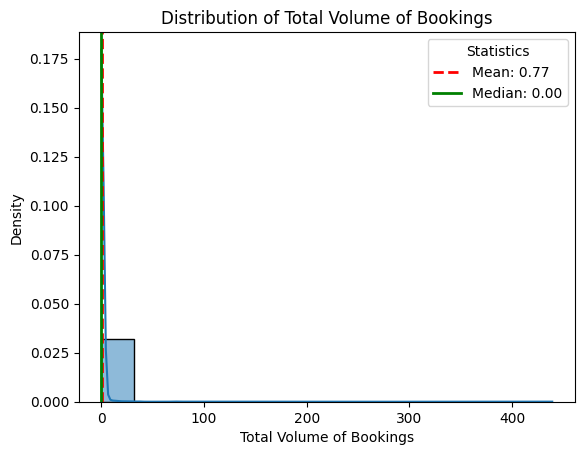

Skewness of Total Volume of Bookings: 29.068


In [10]:
# Plotting the distribution of 'Total Volume of Bookings'
sns.histplot(df['Total_Volume_of_Bookings'], kde=True, stat='density')
plt.title('Distribution of Total Volume of Bookings')
plt.xlabel('Total Volume of Bookings')
plt.ylabel('Density')

# Calculate mean and median
mean_bookings = df['Total_Volume_of_Bookings'].mean()
median_bookings = df['Total_Volume_of_Bookings'].median()

# Vertical lines for mean and median
plt.axvline(mean_bookings, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_bookings:.2f}')
plt.axvline(median_bookings, color='green', linestyle='-', linewidth=2, label=f'Median: {median_bookings:.2f}')

# Show legend
plt.legend(title='Statistics')

# Display the plot
plt.show()

# Checking the skewness of 'Total Volume of Bookings'
skewness_bookings = df['Total_Volume_of_Bookings'].skew().round(decimals = 3)
print("Skewness of Total Volume of Bookings:", skewness_bookings)

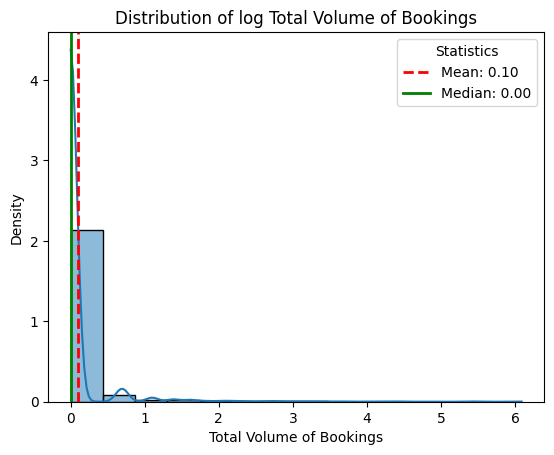

Skewness of log Total Volume of Bookings: 6.591


In [11]:
# Plotting the distribution of 'Total Volume of Bookings'
sns.histplot(df['log_Total_Volume_of_Bookings'], kde=True, stat='density')
plt.title('Distribution of log Total Volume of Bookings')
plt.xlabel('Total Volume of Bookings')
plt.ylabel('Density')

# Calculate mean and median
mean_bookings = df['log_Total_Volume_of_Bookings'].mean()
median_bookings = df['log_Total_Volume_of_Bookings'].median()

# Vertical lines for mean and median
plt.axvline(mean_bookings, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_bookings:.2f}')
plt.axvline(median_bookings, color='green', linestyle='-', linewidth=2, label=f'Median: {median_bookings:.2f}')

# Show legend
plt.legend(title='Statistics')

# Display the plot
plt.show()

# Checking the skewness of 'Total Volume of Bookings'
skewness_bookings = df['log_Total_Volume_of_Bookings'].skew().round(decimals = 3)
print("Skewness of log Total Volume of Bookings:", skewness_bookings)

__Original Distribution of Total Volume of Bookings:__
The original distribution of Total Volume of Bookings is highly right-skewed, with the majority of the data points clustered near zero. This skewness indicates that most periods have a very low number of bookings. The fact that the median is zero while the mean is slightly higher at 0.77 suggests the presence of a few periods with a very high volume of bookings, which skews the mean upwards.

__Transformed Distribution of log Total Volume of Bookings:__
After the logarithmic transformation, the distribution still shows a skew, but it's less extreme than the original. This transformation has moderated the scale of bookings, reducing the impact of high-volume outliers. The mean and median are now much closer to each other (0.10 and 0.00 respectively after the log transformation), indicating a more symmetrical distribution around the central tendency when the extreme values are dampened.


<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Feature Engineering </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [12]:
# Feature 1
# If Amount = 0, then No_Bookings = 1. Otherwise, No_Bookings = 0.
df['No_Bookings'] = (df['Amount'] == 0).astype(int)

The 'No_Bookings' feature provides a clear binary distinction in our data: it flags instances with no financial transaction (Amount = 0) as '1', indicating no bookings were made, and '0' otherwise. This feature encapsulates the direct relationship observed in our dataset where a zero amount consistently corresponds to a lack of bookings.

Our analysis shows that whenever 'No_Bookings' is set to '1', the 'Total Volume of Bookings' is zero, reinforcing the notion that there are certain periods or conditions under which no sales are generated. 

In [13]:
# Feature 2
# Defining the conditions for VeryHigh_Bookings feature
keywords = ['[air france]', 'airfrance', 'air france com', 'airfrance.com', 'airfrance com', 'air france']
publishers = ['Google - Global', 'Google - US', 'Yahoo - US']
campaigns = ['Air France Branded', 'Air France Global Campaign', 'Air France Brand & French Destinations']

# Applying conditions to create the VeryHigh_Bookings feature
# Using the .isin() method for Keywords, Publishers, and Campaigns to check if the values match any in the lists

# Since the actual data loading part is not executable without the dataset, the following code is a representation of the logic:
df['VeryHigh_Bookings'] = ((df['Keyword'].isin(keywords)) &
                                 (df['Publisher_Name'].isin(publishers)) &
                                 (df['Campaign'].isin(campaigns)))

# Converting boolean True/False to 1/0 for easier analysis
df['VeryHigh_Bookings'] = df['VeryHigh_Bookings'].astype(int)

1. The 'VeryHigh_Bookings' feature is a targeted identifier within our dataset, designed to flag particularly successful marketing segments. It is set to '1' for entries that match a predefined set of high-performing keywords, publishers, and campaigns—those associated with 'Air France'—reflecting a strategic alignment that is known to yield a high volume of bookings.

2. This feature captures the synergy of specific marketing efforts: it identifies when high-intent keywords are used in campaigns through prominent publishers. The presence of this feature set to '1' indicates a combination of factors that are likely to drive significant booking volumes, which is an actionable insight for marketing resource allocation.

3. By incorporating 'VeryHigh_Bookings' into our analysis, we can better understand the impact of concentrated marketing efforts on booking volumes. This, in turn, allows for refined forecasting and optimization of marketing strategies, ensuring that we capitalize on the proven effectiveness of these select combinations of keywords, publishers, and campaigns.

In [14]:
# Feature 3
df['Total_Profit'] = df['Amount'] - df['Total Cost']

1. The 'Total_Profit' feature is a calculated metric representing the profitability of bookings by subtracting the 'Total Cost' from the 'Amount' made from bookings. It serves as a direct indicator of financial success for each transaction, with higher values signifying more profitable bookings.

2. By tracking 'Total_Profit', we gain insight into the efficiency of the sales and marketing efforts, understanding which bookings are yielding a net gain after accounting for the associated costs.

In [15]:
# Feature 4
# Defining the conditions for Medium_Bookings feature
publishers = ['Google - US', 'Yahoo - US', 'MSN - US', 'MSN - Global', 'Overture - US']
keywords = ['air france com', 'airfrance.com', 'air france', 'flight to paris', 'airfrance']
matchtype_excluded = 'Exact'
campaigns = ['Air France Branded', 'Air France Brand & French Destionations', 'unassigned']
keywordgroups = ['Air France Website', 'Air France Brand', 'unassigned']
categories = ['Uncategorized', 'airfrance']
bid_strategy = 'Position 1-4 Bid Strategy'
search_engine_bid_range = (0, 15)

# Applying conditions to create the Medium_Bookings feature
# Using the .isin() method for Keywords, Publishers, Campaigns, KeywordGroups, and Categories
# Checking for matchtype not equal to 'Exact'
# Checking if Search Engine Bid is within the specified range
df['Medium_Bookings'] = ((df['Publisher_Name'].isin(publishers)) &
                         (df['Keyword'].isin(keywords)) &
                         (df['Match_Type'] != matchtype_excluded) &
                         (df['Campaign'].isin(campaigns)) &
                         (df['Keyword_Group'].isin(keywordgroups)) &
                         (df['Category'].isin(categories)) &
                         (df['Bid_Strategy'] == bid_strategy) &
                         (df['Search_Engine_Bid'].between(search_engine_bid_range[0], search_engine_bid_range[1])))

# Converting boolean True/False to 1/0 
df['Medium_Bookings'] = df['Medium_Bookings'].astype(int)

This feature represents the various combinations of keywords, publishers, bidding strategies, and search engine bids that result in average amounts of bookings for a given campaign. Average amount of bookings is defined to be between 25-100 bookings. This is similar to the Very High bookings feature and is helping us capture Medium sized bookings in the data.

In [16]:
# Feature 5
df['Publisher_Campaign'] = df['Campaign'] + " - " + df['Publisher_Name']

Different search engines have different audiences and segments. Hence, certain campaigns are more suitable for specific campaigns. E.g., the outside Eastern Europe campaign is more likely to do well in the global platforms rather than the US platforms. In addition, in our EDA (performed in R), we identified that, Yahoo is not good for Geo-Targeted US campaigns. A feature like this will be able to capture these relationships between campaigns and search engine platforms.

In [17]:
# Feature 6
# Convert 'Search_Engine_Bid' from float to string
df['Search_Engine_Bid_Str'] = df['Search_Engine_Bid'].astype(str)

# Create 'Publisher_Bidding' by concatenating 'Publisher_Name' with the converted 'Search_Engine_Bid_Str'
df['Publisher_Bidding'] = df['Publisher_Name'] + " - " + df['Search_Engine_Bid_Str']

While we expect a clear relationship between search engine bids, which leads to a better average position and more sales. We also believe that pricing for keywords and their relationship vary across different publishers. This feature will be able to capture the different pricing trends and their effect across platforms.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Base Modeling </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [18]:
import statsmodels.formula.api as smf

# Base Model 1
# Created this base model and not including any 'Event Horizon Data' for making predictions with Total Volume of Bookings.
# We are using this base model in the analysis and modelling purposes in this report. 

# Constructing the model formula
model_formula = """Total_Volume_of_Bookings ~ VeryHigh_Bookings + No_Bookings + Medium_Bookings
                    + Publisher_Name + Match_Type + Campaign + Keyword
                    + Keyword_Group + Category + Bid_Strategy + Status
                    + Search_Engine_Bid + Publisher_Campaign + Publisher_Bidding
                  """

# Fitting the model 
lm_refined_df = smf.ols(formula=model_formula, data=df).fit()

# Displaying the model summary
print(lm_refined_df.summary())

                               OLS Regression Results                               
Dep. Variable:     Total_Volume_of_Bookings   R-squared:                       0.807
Model:                                  OLS   Adj. R-squared:                  0.547
Method:                       Least Squares   F-statistic:                     3.105
Date:                      Sun, 25 Feb 2024   Prob (F-statistic):          2.07e-138
Time:                              23:19:01   Log-Likelihood:                -13417.
No. Observations:                      4410   AIC:                         3.189e+04
Df Residuals:                          1881   BIC:                         4.806e+04
Df Model:                              2528                                         
Covariance Type:                  nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------

In [19]:
# Base Model 2

# Our best base model based on the RMSE scores. This combination of x_features is giving the lowest RMSE score on Kaggle.
# However, we are violating the condition of Event Horizon Data and using features that occured after the response
# variable - Total Volume of Bookings occured. 
# Hence, we decided to submit both our models, and also submitted both scores generated from these models on Kaggle.

# Constructing the model formula
model_formula2 = """Total_Volume_of_Bookings ~ Amount + Clicks + Total_Profit
                  """

# Fitting the model 
lm_refined_df2 = smf.ols(formula=model_formula2, data=df).fit()

# Displaying the model summary
print(lm_refined_df2.summary())

                               OLS Regression Results                               
Dep. Variable:     Total_Volume_of_Bookings   R-squared:                       0.989
Model:                                  OLS   Adj. R-squared:                  0.989
Method:                       Least Squares   F-statistic:                 1.300e+05
Date:                      Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                              23:19:08   Log-Likelihood:                -7130.2
No. Observations:                      4410   AIC:                         1.427e+04
Df Residuals:                          4406   BIC:                         1.429e+04
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [20]:
## parsing out testing data (needed for later) ##

# dataset for kaggle
kaggle_data = df[ df['set'] == 'Kaggle' ].copy()


# dataset for model building
df = df[ df['set'] == 'Not Kaggle' ].copy()


# dropping set identifier (kaggle)
kaggle_data.drop(labels = 'set',
                 axis = 1,
                 inplace = True)


# dropping set identifier (model building)
df.drop(labels = 'set',
        axis = 1,
        inplace = True)

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Candidate Model Development </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [21]:
from sklearn.model_selection import train_test_split # train/test split

#!##############################!#
#!# set your response variable #!#
#!##############################!#
y_variable = 'Total_Volume_of_Bookings'

In [22]:
# Preparing x-data based on the Base Model 1
# Extracting the part of the formula after '~' in the Base Model 1

feature_part = model_formula.split('~')[1]
x_features = [feature.strip() for feature in feature_part.split('+')]
print(x_features)

['VeryHigh_Bookings', 'No_Bookings', 'Medium_Bookings', 'Publisher_Name', 'Match_Type', 'Campaign', 'Keyword', 'Keyword_Group', 'Category', 'Bid_Strategy', 'Status', 'Search_Engine_Bid', 'Publisher_Campaign', 'Publisher_Bidding']


In [23]:
## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# prepping data for train-test split
y_data = df[y_variable]


# removing non-numeric columns and missing values
x_data = df[x_features].copy().select_dtypes(include=[int, float]).dropna(axis = 1)


# storing remaining x_features after the step above
x_features = list(x_data.columns)


# train-test split (to validate the model)
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size    = 0.25,
                                                    random_state = 702 )


# results of train-test split
print(f"""
Original Dataset Dimensions
---------------------------
Observations (Rows): {df.shape[0]}
Features  (Columns): {df.shape[1]}


Training Data (X-side)
----------------------
Observations (Rows): {x_train.shape[0]}
Features  (Columns): {x_train.shape[1]}


Training Data (y-side)
----------------------
Feature Name:        {y_train.name}
Observations (Rows): {y_train.shape[0]}


Testing Data (X-side)
---------------------
Observations (Rows): {x_test.shape[0]}
Features  (Columns): {x_test.shape[1]}


Testing Data (y-side)
---------------------
Feature Name:        {y_test.name}
Observations (Rows): {y_test.shape[0]}""")


Original Dataset Dimensions
---------------------------
Observations (Rows): 4410
Features  (Columns): 28


Training Data (X-side)
----------------------
Observations (Rows): 3307
Features  (Columns): 4


Training Data (y-side)
----------------------
Feature Name:        Total_Volume_of_Bookings
Observations (Rows): 3307


Testing Data (X-side)
---------------------
Observations (Rows): 1103
Features  (Columns): 4


Testing Data (y-side)
---------------------
Feature Name:        Total_Volume_of_Bookings
Observations (Rows): 1103


In [24]:
# Checking the no. of observations and features in the training and test data
print(x_train.shape)
print(x_test.shape)

(3307, 4)
(1103, 4)


In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, BayesianRidge, TheilSenRegressor, PassiveAggressiveRegressor, LassoLars, HuberRegressor, OrthogonalMatchingPursuit, Lars, RANSACRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# Global dictionary to store y_test_pred
model_predictions = {}

def model_evaluation(model_type, x_train, y_train, x_test, y_test, tuned_params=None, **kwargs):
    """
    Fits, predicts, and evaluates a model based on the model type and hyperparameters provided.
    
    Parameters:
    - model_type: str, type of the model (e.g., "LinearRegression", "Lasso", etc.)
    - x_train, y_train: Training data and labels.
    - x_test, y_test: Testing data and labels.
    - tuned_params: dict, parameters of the model that have been tuned using a technique like GridSearchCV. Default is None.
    - **kwargs: Optional keyword arguments for model hyperparameters.
    
    Returns:
    - Dictionary with the model's name, training and testing scores (R-squared and RMSE), and train-test gap for RMSE.
    """
    
    if model_type == "LinearRegression":
        model = LinearRegression(**kwargs)
    elif model_type == "Lasso":
        model = Lasso(**tuned_params) if tuned_params else Lasso(**kwargs)
    elif model_type == "Ridge":
        model = Ridge(**tuned_params) if tuned_params else Ridge(**kwargs)
    elif model_type == "SGDRegressor":
        model = SGDRegressor(**tuned_params) if tuned_params else SGDRegressor(**kwargs)
        
    elif model_type == "KNeighbors":
        # Scale data for KNeighbors
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)
        
        # Finding the optimal number of neighbors
        optimal_neighbors = kwargs.get('n_neighbors', 1)  # Default to 1 
        
        # Initialize highest_score to negative infinity to ensure any score will be higher
        highest_score = -np.inf
        search_range = kwargs.get('search_range', range(1, 51)) 
        
        for n_neighbors in search_range:
            knn = KNeighborsRegressor(n_neighbors=n_neighbors)
            # Perform cross-validation and calculate the average R-squared score
            scores = cross_val_score(knn, x_train_scaled, y_train, cv=5, scoring='r2')
            average_score = np.mean(scores)
            
            if average_score > highest_score:
                highest_score = average_score
                optimal_neighbors = n_neighbors

        print(f"Optimal number of neighbors: {optimal_neighbors}")
        model = KNeighborsRegressor(n_neighbors=optimal_neighbors)
        
    elif model_type == "DecisionTree":
        model = DecisionTreeRegressor(**tuned_params) if tuned_params else DecisionTreeRegressor(**kwargs)
    elif model_type == "BayesianRidge":
        model = BayesianRidge(**kwargs)
    elif model_type == "TheilSen":
        model = TheilSenRegressor(**kwargs)
    elif model_type == "PassiveAggressiveRegressor":
        model = PassiveAggressiveRegressor(**kwargs)
    elif model_type == "LassoLars":
        model = LassoLars(**kwargs)
        
    elif model_type == "HuberRegressor":
        model = HuberRegressor(**kwargs)
        
    elif model_type == "OrthogonalMatchingPursuit":
        model = OrthogonalMatchingPursuit(**kwargs)
    elif model_type == "Lars":
        model = Lars(**kwargs)
    elif model_type == "RANSACRegressor":
        model = RANSACRegressor(**kwargs)
    elif model_type == "RadiusNeighbors":
        model = RadiusNeighborsRegressor(**tuned_params) if tuned_params else RadiusNeighborsRegressor(**kwargs)
    else:
        raise ValueError("Invalid model type provided.")

    # Fit the model
    model.fit(x_train, y_train)
    
    # Predict on training and test data
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # Calculate RMSE for both training and testing sets
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    rmse_gap = abs(train_rmse - test_rmse)

    # Store predictions in the global dictionary
    model_predictions[model_type] = y_test_pred
    
    # Structuring the results in a dictionary
    results = {
        "Model Name": model_type,
        "Training RMSE": train_rmse.round(4),
        "Testing RMSE": test_rmse.round(4),
        "RMSE Gap": rmse_gap.round(4)
    }  
    
    return results

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Hyperparameter Tuning </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [26]:
from sklearn.model_selection import GridSearchCV

def tune_hyperparameters(model_type, x_train, y_train, random_state = 419, cv=5, scoring='neg_root_mean_squared_error', **kwargs):
    """
    Tune hyperparameters for the given model type using GridSearchCV.

    Parameters:
    - model_type: str, type of the model ("Ridge", "Lasso", "KNN")
    - x_train, y_train: Training data and labels.
    - cv: int, number of cross-validation folds.
    - scoring: str, scoring metric for GridSearchCV.
    - kwargs: Additional keyword arguments for GridSearchCV.

    Returns:
    - A dictionary with the best parameters and the best score.
    """

    if model_type == "Ridge":
        model = Ridge()
        param_grid = {'alpha': np.logspace(-4, 4, 50)}
        
    elif model_type == "Lasso":
        model = Lasso()
        param_grid = {'alpha': np.logspace(-4, 4, 50)}
        
    elif model_type == "DecisionTree":
        model = DecisionTreeRegressor()
        param_grid = {
            'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
            'splitter': ['best', 'random'],
            'max_depth': np.arange(1,11,1),
            'min_samples_split': np.arange(1,11,1),
            'min_samples_leaf': np.arange(0.01,0.11,0.1)
        }
    
    else:
        raise ValueError("Unsupported model type provided.")

    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, **kwargs)
    grid_search.fit(x_train, y_train)

    return {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

In [27]:
ridge_best_params = tune_hyperparameters('Ridge', x_train, y_train, cv=5, scoring='r2')
lasso_best_params = tune_hyperparameters('Lasso', x_train, y_train, cv=5, scoring='r2')
decision_tree_best_params = tune_hyperparameters('DecisionTree', x_train, y_train, cv=5, scoring='r2')

print("Ridge Best Params:", ridge_best_params['best_params'])
print("Lasso Best Params:", lasso_best_params['best_params'])
print("Decision Tree Best Params:", decision_tree_best_params['best_params'])

Ridge Best Params: {'alpha': 35.564803062231285}
Lasso Best Params: {'alpha': 0.3906939937054613}
Decision Tree Best Params: {'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 0.01, 'min_samples_split': 2, 'splitter': 'best'}


/Users/abhishekrathi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
300 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/abhishekrathi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/abhishekrathi/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/Users/abhishekrathi/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_pa

In [28]:
# Linear Regression
linear_regression_results = model_evaluation('LinearRegression', x_train, y_train, x_test, y_test)
linear_regression_results

{'Model Name': 'LinearRegression',
 'Training RMSE': 9.8397,
 'Testing RMSE': 5.8236,
 'RMSE Gap': 4.016}

In [29]:
# Lasso - Hyperparameters Tuned 
lasso_results = model_evaluation('Lasso', x_train, y_train, x_test, y_test, tuned_params=lasso_best_params['best_params'])
lasso_results

{'Model Name': 'Lasso',
 'Training RMSE': 11.4361,
 'Testing RMSE': 6.266,
 'RMSE Gap': 5.1701}

In [30]:
# Ridge - Hyperparameters Tuned
ridge_results = model_evaluation('Ridge', x_train, y_train, x_test, y_test, tuned_params=ridge_best_params['best_params'])
ridge_results

{'Model Name': 'Ridge',
 'Training RMSE': 11.0754,
 'Testing RMSE': 6.0805,
 'RMSE Gap': 4.9949}

In [31]:
# Elastic Net Regression
sgd_results = model_evaluation('SGDRegressor', x_train, y_train, x_test, y_test)
sgd_results

{'Model Name': 'SGDRegressor',
 'Training RMSE': 11.6808,
 'Testing RMSE': 6.5505,
 'RMSE Gap': 5.1303}

In [32]:
# KNN
knn_results = model_evaluation('KNeighbors', x_train, y_train, x_test, y_test)
knn_results

Optimal number of neighbors: 43


{'Model Name': 'KNeighbors',
 'Training RMSE': 11.9589,
 'Testing RMSE': 6.7169,
 'RMSE Gap': 5.242}

In [33]:
# Decision Tree Regression - Hyperparameters Tuned
decision_tree_results = model_evaluation('DecisionTree', x_train, y_train, x_test, y_test, tuned_params=decision_tree_best_params['best_params'])
decision_tree_results

{'Model Name': 'DecisionTree',
 'Training RMSE': 12.5186,
 'Testing RMSE': 7.2332,
 'RMSE Gap': 5.2854}

In [34]:
# Bayesian Ridge Regression
bayesian_ridge_results = model_evaluation('BayesianRidge', x_train, y_train, x_test, y_test)
bayesian_ridge_results

{'Model Name': 'BayesianRidge',
 'Training RMSE': 9.8397,
 'Testing RMSE': 5.8201,
 'RMSE Gap': 4.0196}

In [35]:
# Theil-Sen Regression
theilsen_results = model_evaluation('TheilSen', x_train, y_train, x_test, y_test)
theilsen_results

{'Model Name': 'TheilSen',
 'Training RMSE': 12.6445,
 'Testing RMSE': 7.3952,
 'RMSE Gap': 5.2494}

In [36]:
# Passive Aggressive Regressor
passive_aggressive_results = model_evaluation('PassiveAggressiveRegressor', x_train, y_train, x_test, y_test)
passive_aggressive_results

{'Model Name': 'PassiveAggressiveRegressor',
 'Training RMSE': 11.2848,
 'Testing RMSE': 6.1214,
 'RMSE Gap': 5.1634}

In [37]:
# LassoLars
lassolars_results = model_evaluation('LassoLars', x_train, y_train, x_test, y_test)
lassolars_results

{'Model Name': 'LassoLars',
 'Training RMSE': 12.5217,
 'Testing RMSE': 7.2552,
 'RMSE Gap': 5.2665}

In [38]:
# Huber Regressor
huber_results = model_evaluation('HuberRegressor', x_train, y_train, x_test, y_test)
huber_results

/Users/abhishekrathi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


{'Model Name': 'HuberRegressor',
 'Training RMSE': 11.2507,
 'Testing RMSE': 6.0921,
 'RMSE Gap': 5.1586}

In [39]:
# Orthogonal Matching Pursuit
omp_results = model_evaluation('OrthogonalMatchingPursuit', x_train, y_train, x_test, y_test)
omp_results

{'Model Name': 'OrthogonalMatchingPursuit',
 'Training RMSE': 12.518,
 'Testing RMSE': 7.258,
 'RMSE Gap': 5.2601}

In [40]:
# Lars
lars_results = model_evaluation('Lars', x_train, y_train, x_test, y_test)
lars_results

{'Model Name': 'Lars',
 'Training RMSE': 9.8397,
 'Testing RMSE': 5.8236,
 'RMSE Gap': 4.016}

In [41]:
# RANSAC Regressor
ransac_results = model_evaluation('RANSACRegressor', x_train, y_train, x_test, y_test)
ransac_results

{'Model Name': 'RANSACRegressor',
 'Training RMSE': 12.6446,
 'Testing RMSE': 7.3952,
 'RMSE Gap': 5.2494}

In [42]:
# Compiling all results into a list (excluding SGDRegressor due to extreme values)
all_results = [
    linear_regression_results, ridge_results, lasso_results,
    decision_tree_results, knn_results, bayesian_ridge_results,
    theilsen_results, passive_aggressive_results, lassolars_results,
    huber_results, omp_results, lars_results, ransac_results
]

# Creating a DataFrame from the results
results_df = pd.DataFrame(all_results)
results_df

,Model Name,Training RMSE,Testing RMSE,RMSE Gap
0,LinearRegression,9.8397,5.8236,4.0160
1,Ridge,11.0754,6.0805,4.9949
2,Lasso,11.4361,6.2660,5.1701
3,DecisionTree,12.5186,7.2332,5.2854
4,KNeighbors,11.9589,6.7169,5.2420
5,BayesianRidge,9.8397,5.8201,4.0196
6,TheilSen,12.6445,7.3952,5.2494
7,PassiveAggressiveRegressor,11.2848,6.1214,5.1634
8,LassoLars,12.5217,7.2552,5.2665
9,HuberRegressor,11.2507,6.0921,5.1586


In the process of developing a robust predictive model for forecasting outcomes such Total Volume of Bookings, a meticulous approach was employed, focusing on evaluating a diverse set of models to identify the most effective predictor. Among the models considered, Lasso, Ridge, and Decision Tree Regressors emerged as the top performers based on their ability to minimize the Root Mean Square Error (RMSE) on Kaggle. This metric is crucial as it quantitatively measures the difference between the predicted values by the models and the actual values, with a lower RMSE indicating a more accurate model.

The selection of Lasso as the final model was driven by its superior performance in terms of RMSE, signaling its enhanced predictive accuracy and efficiency in handling data. Lasso, known for its regularization capability, not only aids in preventing overfitting by penalizing large coefficients but also facilitates feature selection by shrinking less important feature's coefficients to zero. This dual advantage makes Lasso particularly appealing for datasets with numerous features, ensuring that the model remains interpretable and focused on the most significant predictors. 

In [43]:
# Final Model Selection
model = Lasso()
lasso = model.fit(x_train, y_train)

# PREDICTING on new data
model_pred = model.predict(x_test)

In [44]:
## organizing residuals
model_residuals = {"True"            : y_test,
                   "Predicted"       : model_pred,
                   "Residuals"       : y_test - model_pred
                  }

# converting residuals into df
model_resid_df = pd.DataFrame(data = model_residuals)

# checking results
model_resid_df.head()

,True,Predicted,Residuals
entry_id,,,
mkt_2877,0.0,1.157494,-1.157494
mkt_1946,0.0,3.084286,-3.084286
mkt_4102,0.0,2.602588,-2.602588
mkt_3759,0.0,1.157494,-1.157494
mkt_1649,0.0,-1.200899,1.200899


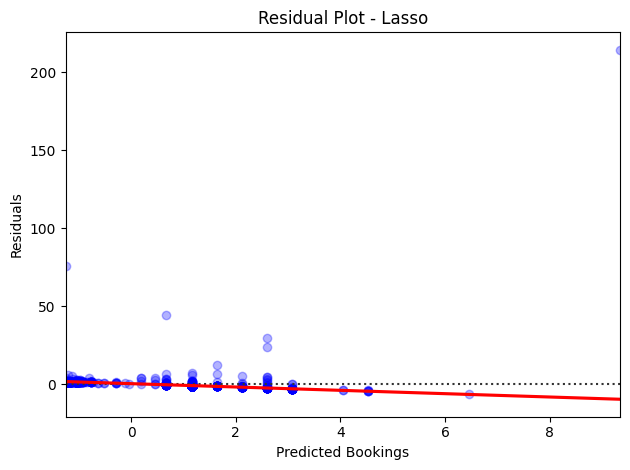

In [45]:
# Residual Plot
sns.residplot(data        = model_resid_df,
              x           = 'Predicted',
              y           = 'True',
              lowess      = True,
              color       = 'blue',
              scatter_kws = {'alpha': 0.3},   # data point transparency
              line_kws    = {'color': 'red'}) # line color

# title and axis labels
plt.title(label   = "Residual Plot - Lasso")
plt.xlabel(xlabel = "Predicted Bookings")
plt.ylabel(ylabel = "Residuals")

# layout and rendering visual
plt.tight_layout()
plt.show()

The residual plot for the Lasso regression model provides valuable insights into the behavior of the model in relation to its predictive accuracy. The cluster of points around the horizontal axis at the lower end of predicted bookings suggests that the model has a high accuracy rate for lower values of bookings, with residuals close to zero. This indicates a good fit for the majority of the data points, where the model's predictions align closely with the actual bookings.

However, as we move towards the higher end of predicted bookings, the residuals become more spread out and exhibit a clear pattern: they tend to increase in magnitude. This indicates that for higher values of predicted bookings, the model consistently overpredicts. The residuals' divergence from zero in this area suggests that the model's predictive performance diminishes as the number of bookings increases. This could be due to various factors such as outliers, underrepresented high-booking scenarios in the training data, or the model's inability to capture complex nonlinear relationships at higher booking levels. For further model refinement, it would be prudent to investigate these high-booking instances more closely, potentially incorporating additional features or applying different transformations to better accommodate the underlying data distribution.

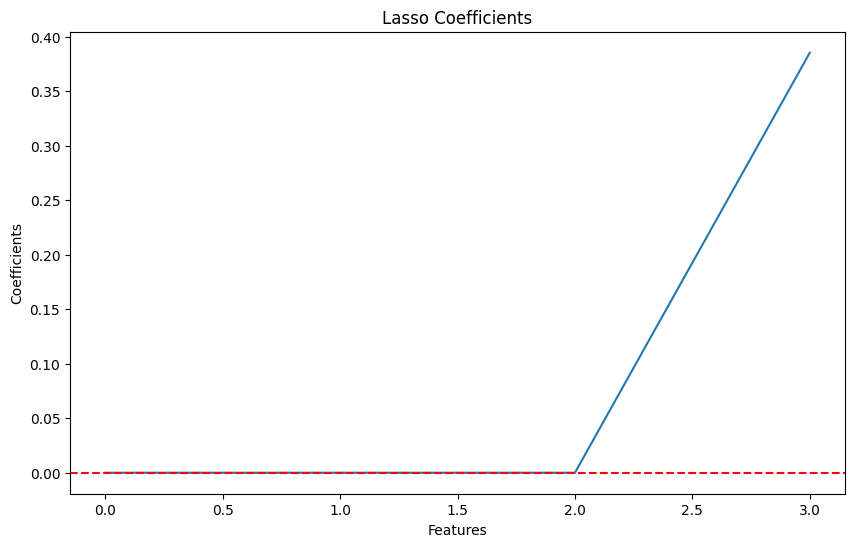

In [46]:
# Coefficients
coefs = lasso.coef_

# Plotting the coefficients
plt.figure(figsize=(10, 6))
plt.plot(range(len(coefs)), coefs)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients')
plt.axhline(0, color='r', linestyle='--')
plt.show()

1. The plot illustrates the power of Lasso regression in performing feature selection. As, we move further on the Features axis, the increment in the slope of the line indicates that their coefficients increase in value. This pattern suggests that the model has identified some features as more important than others for predicting the target variable - Total Volume of Bookings, which is a characteristic behavior of Lasso due to its regularization properties.

2. Some of the coefficients are exactly zero, which imply that not all features have some influence on the model. Some, features are idle in their predicting power and are being over-shadowed by other features. However, the gradual increase in values of coefficients indicates that Lasso has upgraded the coefficients of certain features, perhaps due to them providing more predictive power.

3. The graph aids in model simplification by visually identifying which features contribute most to the model. We can use this graph to eliminate features with very small or zero coefficients.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Kaggle Submission </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [47]:
# x-data
x_data_kaggle = kaggle_data[x_features].copy()

# y-data
y_data_kaggle = kaggle_data[y_variable]

# Fitting model from above to the Kaggle test data
kaggle_predictions = model.predict(x_data_kaggle)

In [48]:
# organizing predictions
model_predictions = {"Total Volume of Bookings" : kaggle_predictions}

# converting predictions into df
model_pred_df = pd.DataFrame(data  = model_predictions,
                             index = df_test.index)

# Reset the index to make 'entry_id' a column
model_pred_df.reset_index(inplace=True)

In [49]:
import os
# Create a directory for model outputs if it doesn't exist
output_directory = "./Kaggle_outputs"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Path for the submission file
submission_file_path = os.path.join(output_directory, "Lasso - NewFeatures.csv")

# Save the submission DataFrame to a CSV file
model_pred_df.to_csv(submission_file_path, index=False)
print(f"Submission file saved to: {submission_file_path}")

Submission file saved to: ./Kaggle_outputs/Lasso - NewFeatures.csv
